In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Carregar os dados
IQ_x_complex = np.load('sent_data_complex.npy')
IQ_y_complex = np.load('received_data_complex.npy')
IQ_x_tuple = np.load('sent_data_tuple.npy')
IQ_y_tuple = np.load('received_data_tuple.npy')

def preprocess_data(data_complex):
    data_real = data_complex.real
    data_imag = data_complex.imag
    data_processed = np.stack([data_real, data_imag], axis=1)
    return data_processed

X = preprocess_data(IQ_x_complex)
Y = preprocess_data(IQ_y_complex)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=52)


Iniciando o treinamento do VAE...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.6578 - val_loss: 0.3626
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.2022 - val_loss: 0.0147
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0109 - val_loss: 0.0067
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 12/50
35/35 ━━━━━━━━━━━

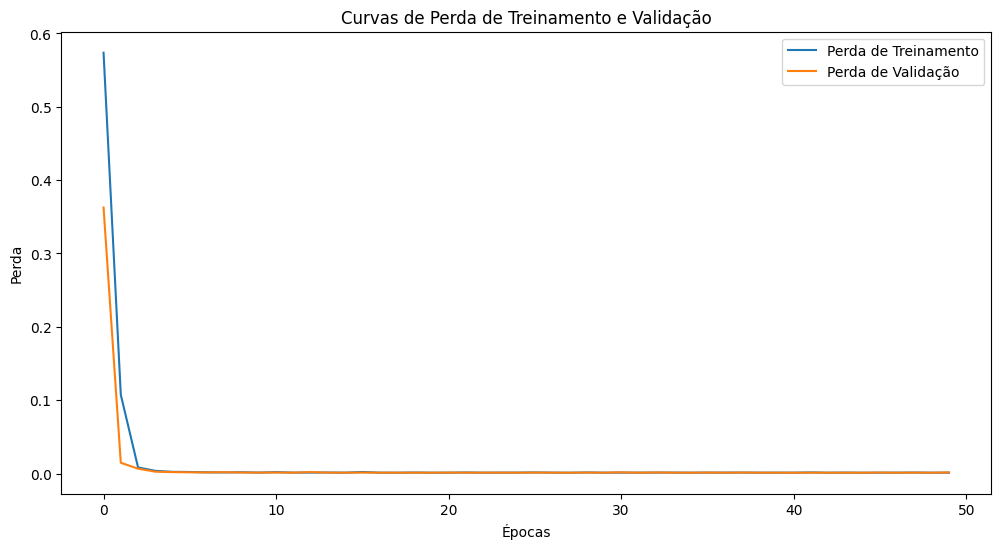

In [21]:
latent_dim = 100  # Dimensionalidade do espaço latente
epochs = 50
batch_size = 32000

# Encoder
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(2,))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    model = models.Model(inputs, [z_mean, z_log_var], name='encoder')
    return model, z_mean, z_log_var

# Decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(2, activation='linear')(x)
    model = models.Model(latent_inputs, outputs, name='decoder')
    return model

# Discriminador
def build_discriminator():
    inputs = layers.Input(shape=(2,))
    x = layers.Dense(64)(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs, name='discriminator')
    return model

# Função de amostragem para VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Função de perda customizada para VAE-GAN
def custom_iq_loss(y_true, y_pred):
    y_true_complex = tf.complex(y_true[:, 0], y_true[:, 1])
    y_pred_complex = tf.complex(y_pred[:, 0], y_pred[:, 1])
    error_magnitude = tf.abs(y_true_complex - y_pred_complex)
    return tf.reduce_mean(tf.square(error_magnitude))

# Montar o modelo
encoder, z_mean, z_log_var = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
discriminator = build_discriminator()

# Compilar e treinar o VAE
vae_inputs = encoder.input
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
vae_outputs = decoder(z)
vae = models.Model(vae_inputs, vae_outputs, name='vae')
vae.compile(optimizer='adam', loss=custom_iq_loss)

print("Iniciando o treinamento do VAE...")
history = vae.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
print("Treinamento do VAE concluído.")

# Plotar as curvas de perda para treinamento e validação
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Curvas de Perda de Treinamento e Validação')
plt.show()


8750/8750 ━━━━━━━━━━━━━━━━━━━━ 3s 363us/step


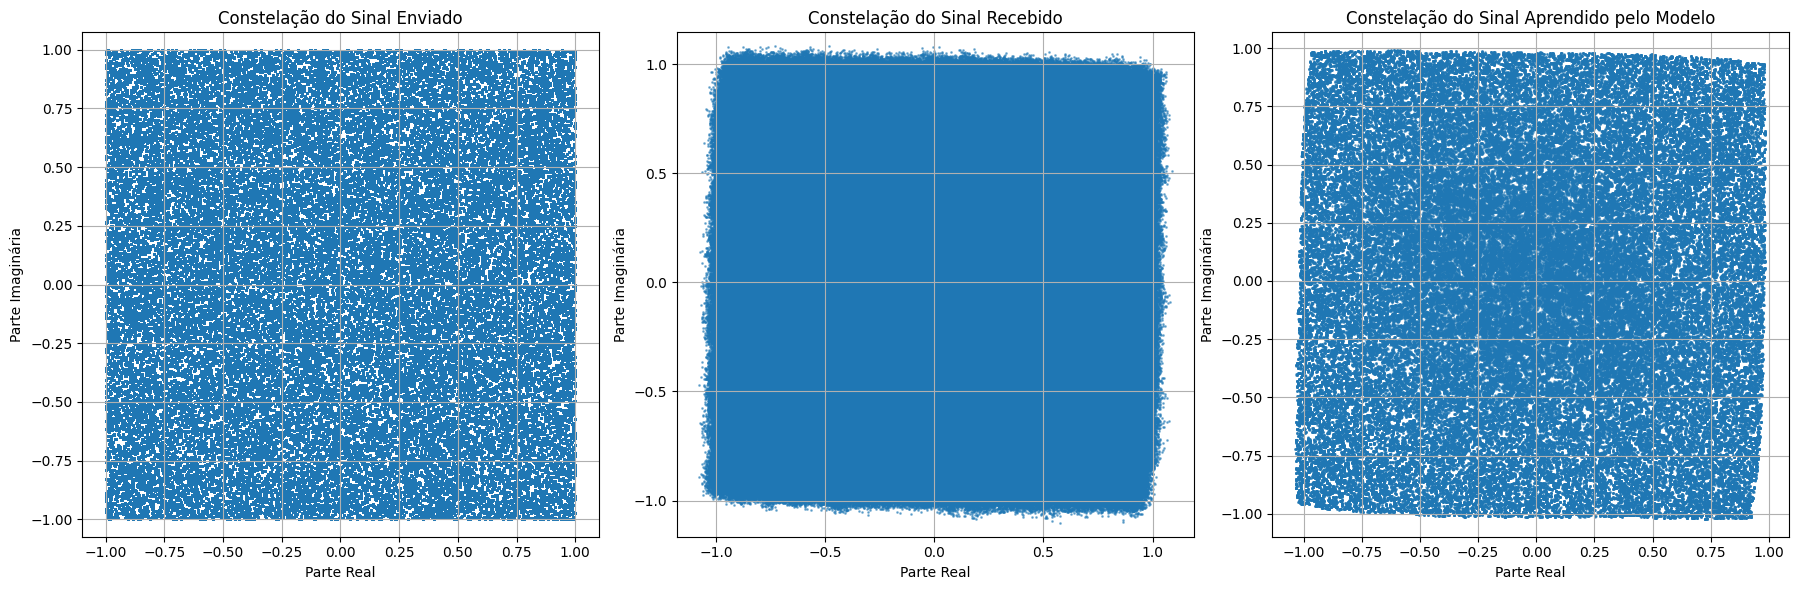

EVM entre original enviado e recebido (%): 4.325448721647263, dB: -27.279376983642578
EVM entre original enviado e aprendido (%): 4.84403558075428, dB: -26.295852661132812
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 18s 406us/step
EVM entre sinais enviados reais e sinais aprendidos (%): 2.998037077486515
EVM entre sinais enviados reais e sinais aprendidos (dB): -30.46325922012329


In [22]:
# Gerar as previsões para Y a partir de X usando o modelo treinado
Y_pred = vae.predict(X_test)  # Supondo que X_test seja o conjunto de teste para X

# Converter Y_pred de volta para a forma complexa para calcular o EVM
Y_pred_complex = Y_pred[:, 0] + 1j * Y_pred[:, 1]

# Converter Y_test de volta para a forma complexa (caso ainda não esteja)
Y_test_complex = Y_test[:, 0] + 1j * Y_test[:, 1]

def plot_constellation(data_complex, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    data_complex = np.array(data_complex)
    ax.scatter(data_complex.real, data_complex.imag, s=1, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('Parte Real')
    ax.set_ylabel('Parte Imaginária')
    ax.grid(True)
    ax.axis('equal')
    ax.set_xlim([data_complex.real.min() - 0.1, data_complex.real.max() + 0.1])
    ax.set_ylim([data_complex.imag.min() - 0.1, data_complex.imag.max() + 0.1])

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_constellation(IQ_x_complex, "Constelação do Sinal Enviado", axs[0])
plot_constellation(IQ_y_complex, "Constelação do Sinal Recebido", axs[1])
plot_constellation(Y_pred_complex, "Constelação do Sinal Aprendido pelo Modelo", axs[2])

plt.tight_layout()
plt.show()

# Função para calcular EVM
def calculate_evm(reference_signal, test_signal):
    error_vector = test_signal - reference_signal
    error_magnitude = np.abs(error_vector)
    average_power = np.mean(np.abs(reference_signal)**2)
    EVM = np.sqrt(np.mean(error_magnitude**2) / average_power)
    EVM_percentage = EVM * 100
    EVM_dB = 20 * np.log10(EVM)
    return EVM_percentage, EVM_dB

# Calculando EVM
EVM_percentage_original, EVM_dB_original = calculate_evm(IQ_x_complex, IQ_y_complex)
EVM_percentage_learned, EVM_dB_learned = calculate_evm(Y_test_complex, Y_pred_complex)

# Mostrar resultados EVM
print(f"EVM entre original enviado e recebido (%): {EVM_percentage_original}, dB: {EVM_dB_original}")
print(f"EVM entre original enviado e aprendido (%): {EVM_percentage_learned}, dB: {EVM_dB_learned}")

# Gerar as previsões para o conjunto completo de sinais enviados
Y_pred_full = vae.predict(X)

# Converter as previsões de volta para a forma complexa
Y_pred_full_complex = Y_pred_full[:, 0] + 1j * Y_pred_full[:, 1]

# Converter o conjunto completo de sinais enviados de volta para a forma complexa, se necessário
IQ_x_complex_full = X[:, 0] + 1j * X[:, 1]

# Calcular EVM entre os sinais enviados reais e os sinais aprendidos (reconstruídos pelo modelo)
EVM_percentage_full, EVM_dB_full = calculate_evm(IQ_x_complex_full, Y_pred_full_complex)

print(f"EVM entre sinais enviados reais e sinais aprendidos (%): {EVM_percentage_full}")
print(f"EVM entre sinais enviados reais e sinais aprendidos (dB): {EVM_dB_full}")


8192/8192 ━━━━━━━━━━━━━━━━━━━━ 3s 311us/step
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 2s 255us/step


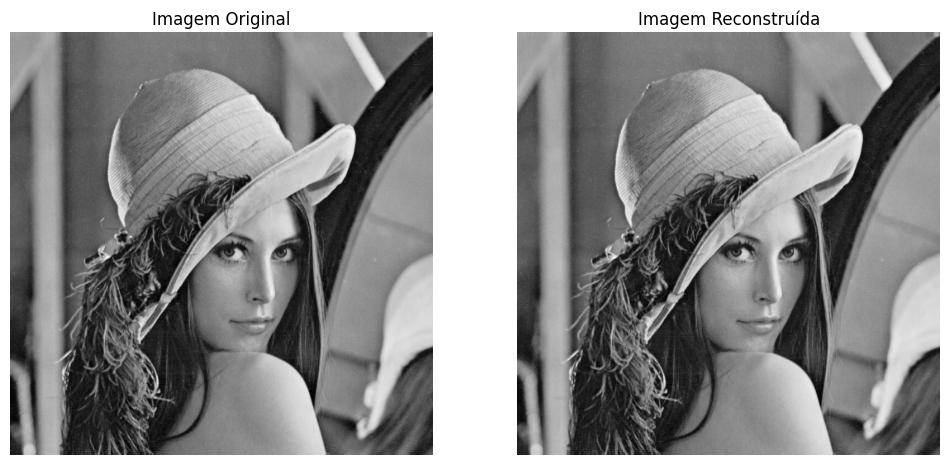

In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Funções auxiliares
def preprocess_data(data_complex):
    data_real = data_complex.real
    data_imag = data_complex.imag
    data_processed = np.stack([data_real, data_imag], axis=1)
    return data_processed

def load_and_preprocess_image(image_path, size=(512, 512)):
    image = Image.open(image_path).convert('L')
    image = image.resize(size)
    image_array = np.array(image) / 255.0
    image_vector = image_array.flatten()
    image_complex = image_vector + 1j * image_vector
    return image_complex, image_array.shape

def reconstruct_image(data_complex, original_shape):
    data_magnitude = np.abs(data_complex)
    data_magnitude = (data_magnitude - data_magnitude.min()) / (data_magnitude.max() - data_magnitude.min())
    image_array = data_magnitude.reshape(original_shape)
    return image_array

# Carregar e pré-processar a imagem
image_path = 'lenna.png'
image_complex, original_shape = load_and_preprocess_image(image_path)

# Pré-processar a imagem para os componentes real e imaginário
image_data = preprocess_data(image_complex)

# Codificar a imagem usando o encoder do VAE
z_mean, z_log_var = encoder.predict(image_data)
z = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(tf.shape(z_mean))

# Decodificar a imagem do espaço latente
reconstructed_image_data = decoder.predict(z)

# Converter os dados reconstruídos de volta para a forma complexa
reconstructed_image_complex = reconstructed_image_data[:, 0] + 1j * reconstructed_image_data[:, 1]

# Reconstruir a imagem a partir dos dados complexos
reconstructed_image = reconstruct_image(reconstructed_image_complex, original_shape)

# Mostrar a imagem original e a reconstruída
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(Image.open(image_path).convert('L'), cmap='gray')
ax[0].set_title('Imagem Original')
ax[0].axis('off')

ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title('Imagem Reconstruída')
ax[1].axis('off')

plt.show()


In [27]:
# Salvar o encoder e o decoder no formato Keras
encoder.save('encoder_model.keras')
decoder.save('decoder_model.keras')



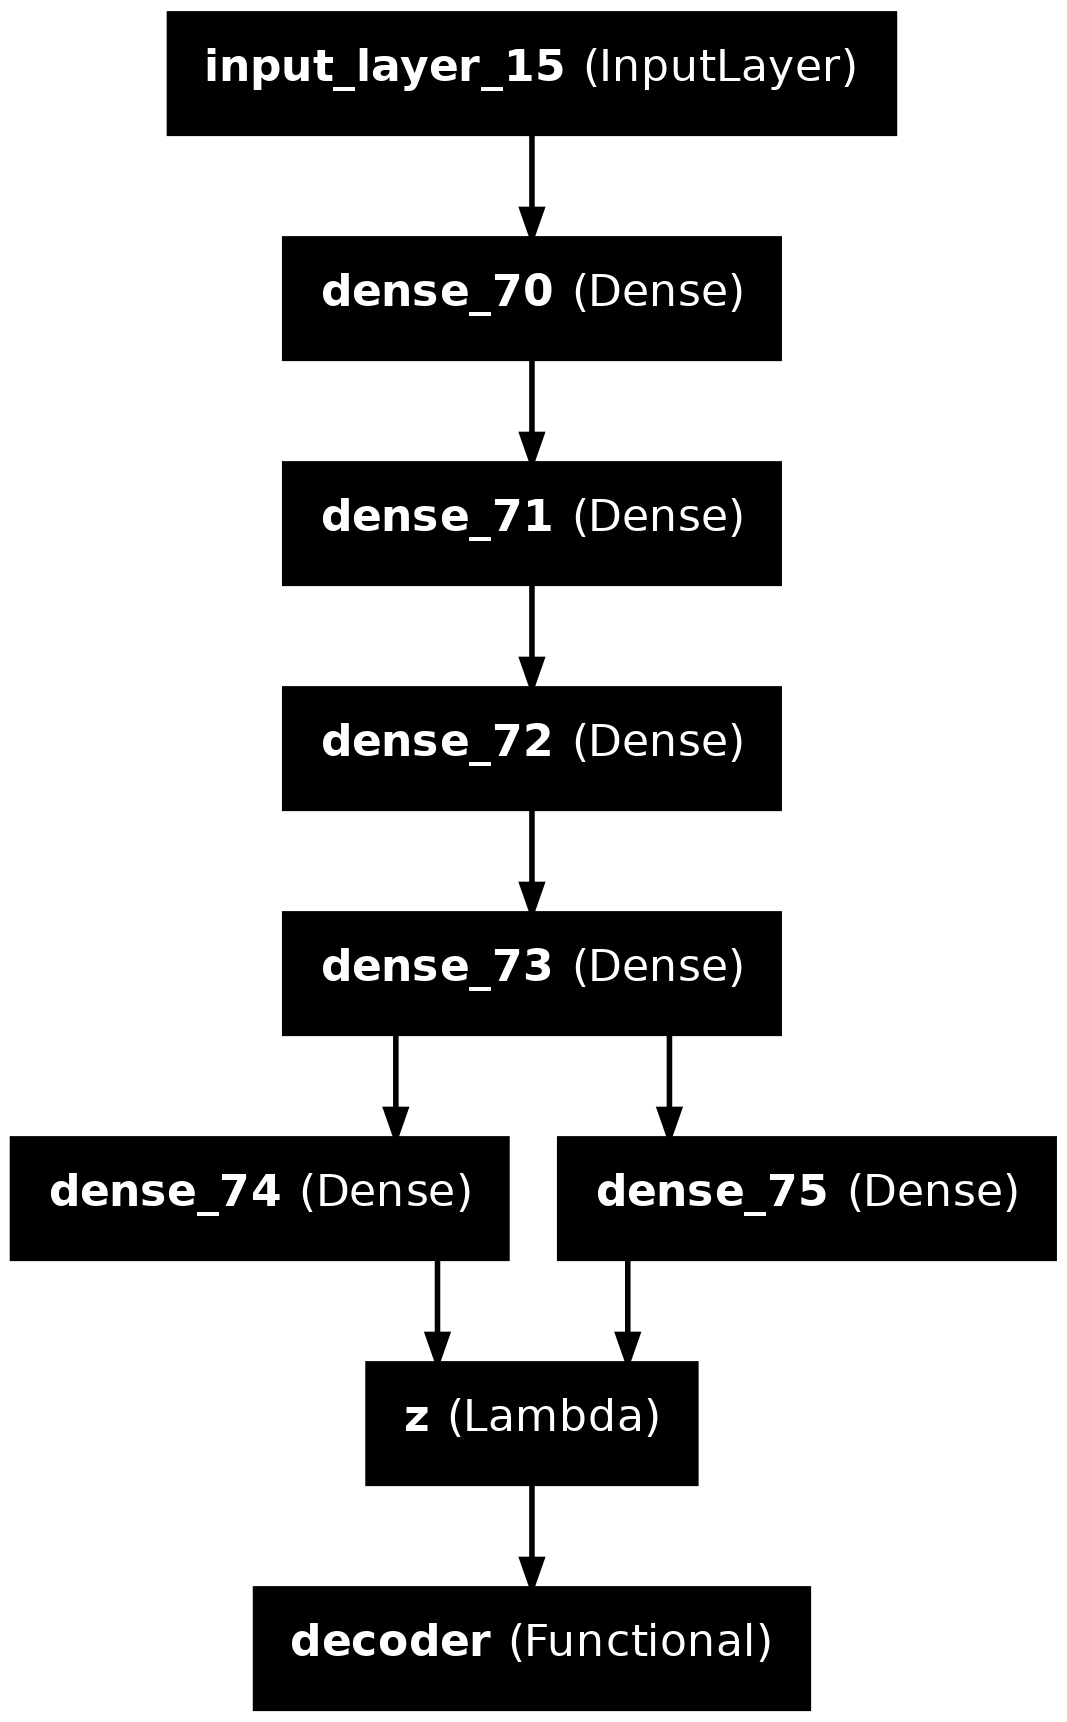

In [25]:
# Salvar esquemático do modelo
tf.keras.utils.plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(vae, to_file='vae.png', show_layer_names=True)
